### More Fun

Hi again! This notebook is dedicated to feature engineering and classifier training. 

In [1]:
# for data munging
import pandas as pd
import numpy as np

# for visualization and pitch drawing
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

# modeling
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# for saving the model
import joblib

%matplotlib inline

In [2]:
# pandas setup - just the way I like it!
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.precision', 3)

I use the smaller representation of the event data to save time. As we have seen before (in the notebook 02), England data is a very good representation of the bigger dataset.

In [3]:
# read in data
events_eng = pd.read_csv("../../csv_files/AI_in_Soccer/02-eventsEng.csv", index_col=0)

#### Usual checks

In [6]:
events_eng.head(3)

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded,phyScore,phyClass,event,x_start_scaled,x_end_scaled,y_start_scaled,y_end_scaled
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78,1,1,1,3,0.046,1,5.0,normal-normal,short_pass,58.8,37.2,39.2,62.4
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75,1,1,1,1,0.082,1,8.0,tall-normal,long_pass,37.2,61.2,62.4,60.0
2,177959173,2499719,1,8,18,Arsenal,1609,Arsenal,england,3319,M. \u00d6zil,MID,29.213,180.0,76.0,left,Pass,Head pass,1H,6.542,51,75,35,71,1,2,1,2,0.109,1,6.0,normal-stocky,short_pass,61.2,42.0,60.0,56.8


In [7]:
events_eng.shape

(565909, 37)

In [8]:
events_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565909 entries, 0 to 643149
Data columns (total 37 columns):
id                 565909 non-null int64
matchId            565909 non-null int64
gameweek           565909 non-null int64
month              565909 non-null int64
hour               565909 non-null int64
teamHome           565909 non-null object
teamId             565909 non-null int64
teamName           565909 non-null object
league             565909 non-null object
playerId           565909 non-null int64
shortName          565909 non-null object
role               565909 non-null object
age                565909 non-null float64
height             565909 non-null float64
weight             565909 non-null float64
foot               565909 non-null object
eventName          565909 non-null object
subEventName       565909 non-null object
matchPeriod        565909 non-null object
eventSec           565909 non-null float64
x_start            565909 non-null int64
y_start    

Looks good!

#### Train - Validation Split

I will just validate the model this book. The field testing is done in the notebook 04, where I link the LSTM and Xgboost models.

Also, I will not use the automated train/val split mechanism for this project. It will be manual for the completeness of the study. In other words, everything about the soccer league is sequential; the matches, the players' physical condition, the grounds' status... everything is impacted by the previous state. I want to honor that and split the dataset by the gameweeks.

There are 38 gameweeks English league. Let's go for something like 80-20. That means, about 31 gameweeks to train and 7 gameweeks to validate.

In [5]:
# define the splitter (dataframe, lower validation limit - exclusive, upper validation limit - inclusive)
def data_splitter(df, week_beg, week_end):
    # train set
    train_ds = df[df['gameweek'] < week_beg]
    # validation set
    val_ds = df[(df['gameweek'] >= week_beg) & (df['gameweek'] <= week_end)]
    
    # ratio info
    print(f"Validation set is {(val_ds.shape[0] / df.shape[0]) * 100:.2f}% of train set.")
    
    return train_ds, val_ds


In [33]:
eng_train, eng_val = data_splitter(events_eng, 31, 38)

Validation set is 21.11% of train set.


Looks good! Let's define our sets and model!

#### Model Building

Let's see what XGBoost classifier can do. 

Ok, but why XGBoost? In my most humble opinion, the events data does not signify a high variance but high bias towards certain events at certain parts of the field such as the dominance of pass around the midfield area (see book 02 for events distribution visualizations of Arsenal). This idea would go along with the method of Xgboost algorithm in a way, starting with high bias (small depth) and corrects the mistakes as it goes by fitting these weak leraners to the residuals of the current predictions. This can work with the dynamic nature of the game of soccer, where the predictibility of the events can also be related to issues additional to coordiantes and roles.  And these issues (such as coach interaction, player wage, real-time reactions of fans, betting) can impact the nature of the game by making it more artifical than natural. To illustrate, a news paper article about the Arsenal midfielder not passing enought and the fans being not happy about it at all can push this player's event chain in the next match towards the passing more than he usually does. That does not help to my prediction parameter because I have no way of accounting for such measures. My only defence would be a model to handle that part. 

This may be very true and on the point or it may be exremely wrong, but it is my reason. There is much learn (people give their years to understand and design such models and I respect that) about the models I work with. If you are an expert in Xgboost and you have corrections or additions, please do not hesistate to contact me about them. I will gladly listen/read.

About the model performance measurement: I use accuracy. Beacuse wrong classification of all the targets (Events: Short pass, Long pass, Game Break, Shot, and Control) are equally costly in both ways. For example, predicting a shot rather than a short pass can pull the defense up to block the shot and create an opening for a short pass and resulting a conceded goal is equally costly as the reverse case where a shot is not predicted and actually happens can end up with a conceded goal. There is an interesting balance in the game.

That's being said, I start with a humble version and build on it. And, I adjusted a few parameters and added an extra function to monitor the model performance:

    1) I keep the tree numbers high for more chances in better foresting and set a limitatin around 20 to 50 to capture the best quality trees. 
    2) I constructed an eval set to keep track of the how the model performs. Let's not forget to set an evaluation platform to screen our model.
    3) Since I deal with a multi-class problem, I make sure to set the number of classes to 6 (number of the target classes) and ojective to multiple softmax. Also, I adjust the evaluation metric to account for multi-class error.
    
Let's define the model first. Then we can modify the sets and the parameters for faster application.

In [38]:
def model_base(X_train, X_val, y_train, y_val, n_estimators, early_stopping_rounds):
    
    # assign sets
    X_train, X_val, y_train, y_val = X_train, X_val, y_train, y_val
    
    # define model
    gbm = xgb.XGBClassifier( 
                           n_estimators=n_estimators,
                           objective="multi:softmax",
                           num_class=5, 
                           random_state=42,
                           n_jobs=-1
                          )
    # setup evaluation set
    eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/val error as we go

    # fit with evaluation set
    model = gbm.fit( 
                        X_train, y_train,
                        eval_set=eval_set,
                        eval_metric='merror',
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=False #gives output log as below.I set it false for presentation purposes.
                       )
    print(f"Train Score: {accuracy_score(y_train, model.predict(X_train, ntree_limit=gbm.best_ntree_limit))}.")
    print(f"Validation Score: {accuracy_score(y_val, model.predict(X_val, ntree_limit=gbm.best_ntree_limit))}.")
    xgb.plot_importance(model);

I set the verbose to False to avoid crowded looks, if you ever want to monitor the performance tree by tree set it to True.

#### Trial (a) - Simple
First, I try the 2 feature set of just coordinates and observe the performance 

In [37]:
# train features and target sets
X_train_a = eng_train[['x_start', 'y_start']]
y_train_a = eng_train['event']

# validation features and target sets
X_val_a = eng_val[['x_start', 'y_start']]
y_val_a = eng_val['event']

I can use the scaled coordinates as input features. But, it will not change the score (scaling by multiplication and division).

Train Score: 0.5896621432765581.
Validation Score: 0.591337586940277.


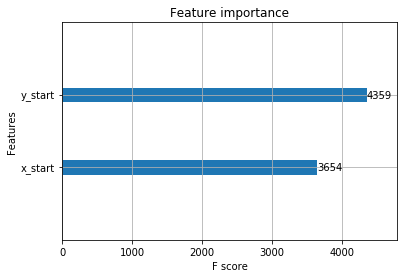

In [321]:
# base model a fit
model_base(X_train_a, X_val_a, y_train_a, y_val_a, 30000, 30)

#### Trial (b) - Time factor
Let's increase the complexity by adding the time factor (`eventSec`) and the match period to signify the seperation of time (`matchPeriodNum`).

In [39]:
# train features and target sets
X_train_b = eng_train[['x_start', 'y_start', 
                       'eventSec', 'matchPeriodNum']]
y_train_b = eng_train['event']

# validation features and target sets
X_val_b = eng_val[['x_start', 'y_start',
                   'eventSec', 'matchPeriodNum']]
y_val_b = eng_val['event']

Train Score: 0.590417847263442.
Validation Score: 0.5918010280107824.


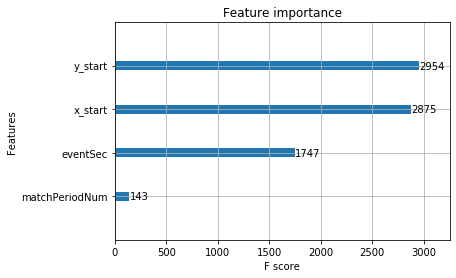

In [40]:
# base model b fit
model_base(X_train_b, X_val_b, y_train_b, y_val_b, 30000, 30)

#### Trial (c) - Linking coordinates
Not much of a progress. Let's add the end coordinates of events. This may actually improve the score. Because it will link the observations in the same match period in a given match. 

In [41]:
# train features and target sets
X_train_c = eng_train[['x_start', 'y_start', 
                       'x_end', 'y_end',
                       'eventSec', 'matchPeriodNum']]
y_train_c = eng_train['event']

# validation features and target sets
X_val_c = eng_val[['x_start', 'y_start', 
                   'x_end', 'y_end',
                   'eventSec', 'matchPeriodNum']]
y_val_c = eng_val['event']

Train Score: 0.7151403836892856.
Validation Score: 0.710641753310898.


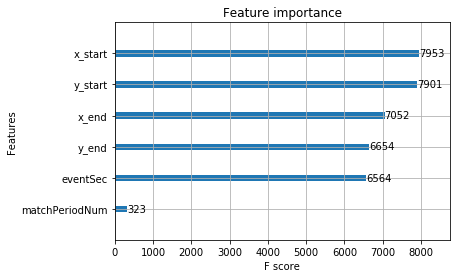

In [42]:
# base model c fit
model_base(X_train_c, X_val_c, y_train_c, y_val_c, 30000, 30)

#### Trial (d) - Adding roles
Much better! Let's take the match period and event second off the set. Match period is already indirectly accounted by bringing in the corrdinates where events end. And the events second does not add much to the performance.  My personal choice would be the role of the player. It will have direct impat on the location. I believe I have three graphs that say so in notebook 02. If not, I will add them. I add the quantified role (1: DEF, 2: MID, and 3: FWD)

In [52]:
# train features and target sets
X_train_d = eng_train[['x_start', 'y_start', 'x_end', 'y_end',
                       'roleNum']]
y_train_d = eng_train['event']

# validation features and target sets
X_val_d = eng_val[['x_start', 'y_start', 'x_end', 'y_end',
                   'roleNum']]
y_val_d = eng_val['event']

Train Score: 0.728523591403389.
Validation Score: 0.7230134611170917.


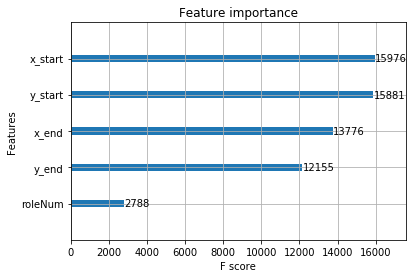

In [45]:
# base model 1d fit
model_base(X_train_d, X_val_d, y_train_d, y_val_d, 30000, 30)

Just a little better. 

In an old version of this notebook, I tried putting more emphasis on the match period by seperating datasets into 2 pieces, 1st half events data and 2nd half events data. I defined 2 seperate XGBoost models based on each match period. However, the accuracy score was 1% lower than the best. I did not include that part here. It was very crowded and confusing. Only thing you need to know is, it did not improve anything.

#### Trial (e) - Categorical coordinates
I try to generalize the coordinates hoping that it may improve the model's performance. I start by generating starting and ending zones of events. Then I recalibrate the train and validation sets.

Let's define the zoner.  The idea is to divide the field into 100 zones starting from lower left corder (0,0) and going from left to right (100, 0) and then up by 10 units (0, 10) and repeat (100, 10)...

In [44]:
def zoner(df, x, y):  
    # tens
    df.loc[(df[y] >= 0) & (df[y] <= 10), "tens"] = 0
    df.loc[(df[y] > 10) & (df[y] <= 20), "tens"] = 10
    df.loc[(df[y] > 20) & (df[y] <= 30), "tens"] = 20
    df.loc[(df[y] > 30) & (df[y] <= 40), "tens"] = 30
    df.loc[(df[y] > 40) & (df[y] <= 50), "tens"] = 40
    df.loc[(df[y] > 50) & (df[y] <= 60), "tens"] = 50
    df.loc[(df[y] > 60) & (df[y] <= 70), "tens"] = 60
    df.loc[(df[y] > 70) & (df[y] <= 80), "tens"] = 70
    df.loc[(df[y] > 80) & (df[y] <= 90), "tens"] = 80
    df.loc[(df[y] > 90) & (df[y] <= 100), "tens"] = 90
    
    # ones
    df.loc[(df[x] >= 0) & (df[x] <= 10), "ones"] = 1
    df.loc[(df[x] > 10) & (df[x] <= 20), "ones"] = 2
    df.loc[(df[x]> 20) & (df[x] <= 30), "ones"] = 3
    df.loc[(df[x] > 30) & (df[x] <= 40), "ones"] = 4
    df.loc[(df[x] > 40) & (df[x] <= 50), "ones"] = 5
    df.loc[(df[x] > 50) & (df[x] <= 60), "ones"] = 6
    df.loc[(df[x] > 60) & (df[x] <= 70), "ones"] = 7
    df.loc[(df[x] > 70) & (df[x] <= 80), "ones"] = 8
    df.loc[(df[x] > 80) & (df[x] <= 90), "ones"] = 9
    df.loc[(df[x] > 90) & (df[x] <= 100), "ones"] = 10
    
    df['zone'] = df['tens'] + df['ones']

In [45]:
# event's starting zone
zoner(events_eng, 'x_start', 'y_start')
events_eng['zone_start'] = events_eng['zone']

In [46]:
# event's ending zone
zoner(events_eng, 'x_end', 'y_end')
events_eng['zone_end'] = events_eng['zone']

In [47]:
# check
events_eng.head(2)

,id,matchId,gameweek,month,hour,teamHome,teamId,teamName,league,playerId,shortName,role,age,height,weight,foot,eventName,subEventName,matchPeriod,eventSec,x_start,y_start,x_end,y_end,leagueNum,footNum,matchPeriodNum,roleNum,eventMin,eventMinRounded,phyScore,phyClass,event,x_start_scaled,x_end_scaled,y_start_scaled,y_end_scaled,tens,ones,zone,zone_start,zone_end
0,177959171,2499719,1,8,18,Arsenal,1609,Arsenal,england,25413,A. Lacazette,FWD,26.599,175.0,73.0,right,Pass,Simple pass,1H,2.759,49,49,31,78,1,1,1,3,0.046,1,5.0,normal-normal,short_pass,58.8,37.2,39.2,62.4,70.0,4.0,74.0,45.0,74.0
1,177959172,2499719,1,8,18,Arsenal,1609,Arsenal,england,370224,R. Holding,DEF,22.284,189.0,75.0,right,Pass,High pass,1H,4.947,31,78,51,75,1,1,1,1,0.082,1,8.0,tall-normal,long_pass,37.2,61.2,62.4,60.0,70.0,6.0,76.0,74.0,76.0


In [49]:
# split again
eng_train_e, eng_val_e = data_splitter(events_eng, 31, 38)

Validation set is 21.11% of train set.


In [50]:
# train features and target sets
X_train_e = eng_train_e[['zone_start', 'zone_end',
                       'roleNum']]
y_train_e = eng_train_e['event']

# validation features and target sets
X_val_e = eng_val_e[['zone_start', 'zone_end',
                   'roleNum']]
y_val_e = eng_val_e['event']

Ok. Let's see if this works as I thought it would.

Train Score: 0.6649583944630478.
Validation Score: 0.6645403251460813.


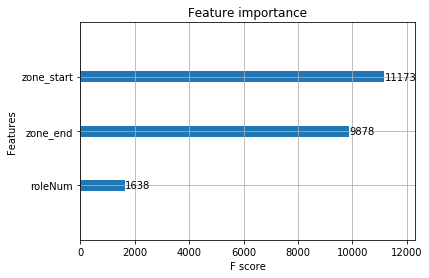

In [51]:
# model e fit
model_base(X_train_e, X_val_e, y_train_e, y_val_e, 30000, 30)

Nope! Not good. This practice reduces the accuracy by 5%. I am back to model version (d). At this point I will stop trials and get inot some hyper-parameter tuning.

This does not mean the features are perfect. There isn't a perfect scenario. However, times is what I do not have with this project. Therefore, I must conculde it temporarily and move on. 73% accuracy is not bad for a soccer event prediction:).

One last thing. Where did all the features we worked in notebook 02 go?  There isn't a rule about using them in the final version just because I worked them. Yes, I tried them in a previous version of this notebook. They did not add any value to the accuracy of the model. Then why have them? I believe that covers it.

### Hyper-Parameter Tuning - Cross Validation with GridSearch

Here I plan to test the model through some ranges of tree depth and learning rate. My aim is to get the best mixture, test it on the small set, and scale it to finalize the model.

I manually tested different values of subsamples, minimum child weight and colsample by tree. They did not impact the model's performance by a considerable amount. Therefore, I leave them at their default values.

Now lest do some gridsearch on the very base feature set by modifying the max_depth. Then I scale the model. I use a very small n_estimators for speed.

In [414]:
from sklearn.model_selection import GridSearchCV

In [416]:
xgbm = xgb.XGBClassifier( 
                       n_estimators=30,   # Small number of trees for speedy Gridsearch
                       objective="multi:softmax",    # multi-class problem 
                       subsample=1,
                       learning_rate=.05,
                       min_child_weight=1,
                       colsample_bytree=1,
                       num_class=5, 
                       random_state=42,
                       n_jobs=-1)       # engage all the cores

# hyper-paramter grid
max_depth_range = range(3, 13)
param_grid = dict(max_depth=max_depth_range)
print(param_grid)

# set the search parameters!
grid = GridSearchCV(xgbm,
                    param_grid,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True)
# fit and search!
grid.fit(X_val_d, y_val_d)

{'max_depth': range(3, 13)}


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.05, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=30, n_jobs=-1,
                                     nthread=None, num_class=5,
                                     objective='multi:softmax', random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(3, 13)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True,

In [420]:
grid_mean_scores = grid.cv_results_["mean_test_score"]
grid_mean_scores

array([0.62674604, 0.64382746, 0.66149337, 0.66727022, 0.67133222,
       0.67421586, 0.67759768, 0.68008854, 0.68188003, 0.68360448])

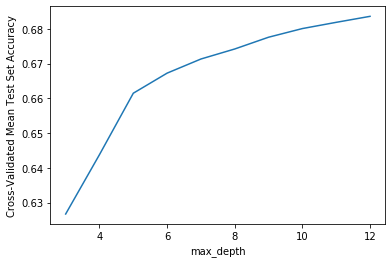

In [421]:
# plot the results
sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
sns.mpl.pyplot.xlabel('max_depth')
sns.mpl.pyplot.ylabel('Cross-Validated Mean Test Set Accuracy');

In [422]:
# what is best model?
print("Best score:",grid.best_score_)
print("Best params:",grid.best_params_)
print("Best estimator:",grid.best_estimator_)

Best score: 0.6836044750031487
Best params: {'max_depth': 12}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=-1,
              nthread=None, num_class=5, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


I see the suggested max_depth for the simple set "a" is 12. It may cause over fitting in the set "d" due to high depth and more features. I will set it to 10 and increase the learning rate to 0.3 and rerun the model on set "d".

In [54]:
# Final Model

# define model
gbm = xgb.XGBClassifier( 
                       n_estimators=30000,  # high number
                       max_depth=10,
                       objective="multi:softmax",
                       learning_rate=0.1, 
                       subsample=1,
                       min_child_weight=.1,
                       colsample_bytree=1,
                       num_class=5, 
                       random_state=42,
                       n_jobs=-1, 
                      )
# setup evaluation set
eval_set=[(X_train_d,y_train_d),(X_val_d,y_val_d)] #tracking train/val error as we go

# fit with evaluation set
model_final = gbm.fit( 
                    X_train_d, y_train_d,
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=30,  # time saver with high tree numbers
                    verbose=True 
                   )


[0]	validation_0-merror:0.328465	validation_1-merror:0.330387
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.323529	validation_1-merror:0.326502
[2]	validation_0-merror:0.325238	validation_1-merror:0.328151
[3]	validation_0-merror:0.322763	validation_1-merror:0.32574
[4]	validation_0-merror:0.322111	validation_1-merror:0.325062
[5]	validation_0-merror:0.320971	validation_1-merror:0.323698
[6]	validation_0-merror:0.3204	validation_1-merror:0.323254
[7]	validation_0-merror:0.319636	validation_1-merror:0.322995
[8]	validation_0-merror:0.318823	validation_1-merror:0.322291
[9]	validation_0-merror:0.318556	validation_1-merror:0.322208
[10]	validation_0-merror:0.317907	validation_1-merror:0.321546
[11]	validation_0-merror:0.317237	validation_1-merror:0.321195
[12]	validation_0-merror:0.316805	validation_1-merror:0.320919
[13]	validation_0-merror:0.3157

[128]	validation_0-merror:0.243406	validation_1-merror:0.272833
[129]	validation_0-merror:0.243274	validation_1-merror:0.272707
[130]	validation_0-merror:0.243044	validation_1-merror:0.272791
[131]	validation_0-merror:0.242636	validation_1-merror:0.272691
[132]	validation_0-merror:0.242401	validation_1-merror:0.27259
[133]	validation_0-merror:0.242148	validation_1-merror:0.27254
[134]	validation_0-merror:0.241856	validation_1-merror:0.272507
[135]	validation_0-merror:0.241503	validation_1-merror:0.272389
[136]	validation_0-merror:0.240898	validation_1-merror:0.272281
[137]	validation_0-merror:0.240524	validation_1-merror:0.272264
[138]	validation_0-merror:0.240112	validation_1-merror:0.272205
[139]	validation_0-merror:0.239912	validation_1-merror:0.272239
[140]	validation_0-merror:0.239536	validation_1-merror:0.272172
[141]	validation_0-merror:0.23931	validation_1-merror:0.272096
[142]	validation_0-merror:0.239012	validation_1-merror:0.271971
[143]	validation_0-merror:0.238694	validati

Train Score: 0.7735516457425721.
Validation Score: 0.7292430559043649.


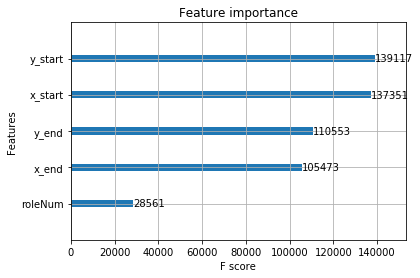

In [55]:
print(f"Train Score: {accuracy_score(y_train_d, model_final.predict(X_train_d, ntree_limit=gbm.best_ntree_limit))}.")
print(f"Validation Score: {accuracy_score(y_val_d, model_final.predict(X_val_d, ntree_limit=gbm.best_ntree_limit))}.")
xgb.plot_importance(model_final);

Excellent! 

I am happy with this (for now). Of course, there are a lot of room for improvement. I have much to learn about the depths of this model and how it is actually perfected on a given data. Xgboost hyper-paramter tuning is not an easy task. I plan to discover it more in the coming days. But for now I have to stop here and train the model on all events and save it for the field test in notebook 04.

Now with the big boy!

In [6]:
# read in data
events = pd.read_csv("../../csv_files/AI_in_Soccer/02-eventsAll.csv", index_col=0)

In [7]:
train, val = data_splitter(events, 31, 38)

Validation set is 19.46% of train set.


Little less than England version. Well, thanks Germany!!

In [10]:
# train features and target sets
X_train = train[['x_start', 'y_start', 'x_end', 'y_end','roleNum']]
y_train = train['event']

# validation features and target sets
X_val = val[['x_start', 'y_start', 'x_end', 'y_end', 'roleNum']]
y_val = val['event']

In [11]:
# Final Model

# define model
gbm = xgb.XGBClassifier( 
                       n_estimators=30000,  # high number
                       max_depth=10,
                       objective="multi:softmax",
                       learning_rate=0.1, 
                       subsample=1,
                       min_child_weight=.1,
                       colsample_bytree=1,
                       num_class=5, 
                       random_state=42,
                       n_jobs=-1, 
                      )
# setup evaluation set
eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/val error as we go

# fit with evaluation set
model_final = gbm.fit( 
                    X_train, y_train,
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=30,  # time saver with high tree numbers
                    verbose=True 
                   )


[0]	validation_0-merror:0.340257	validation_1-merror:0.339791
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.339927	validation_1-merror:0.339431
[2]	validation_0-merror:0.339486	validation_1-merror:0.339258
[3]	validation_0-merror:0.338254	validation_1-merror:0.338393
[4]	validation_0-merror:0.33783	validation_1-merror:0.337918
[5]	validation_0-merror:0.337553	validation_1-merror:0.337747
[6]	validation_0-merror:0.337229	validation_1-merror:0.337385
[7]	validation_0-merror:0.336584	validation_1-merror:0.337007
[8]	validation_0-merror:0.335627	validation_1-merror:0.335992
[9]	validation_0-merror:0.335393	validation_1-merror:0.335649
[10]	validation_0-merror:0.334472	validation_1-merror:0.334822
[11]	validation_0-merror:0.33376	validation_1-merror:0.33406
[12]	validation_0-merror:0.333251	validation_1-merror:0.333516
[13]	validation_0-merror:0.3329

[128]	validation_0-merror:0.26603	validation_1-merror:0.274418
[129]	validation_0-merror:0.265931	validation_1-merror:0.274361
[130]	validation_0-merror:0.265733	validation_1-merror:0.274283
[131]	validation_0-merror:0.265604	validation_1-merror:0.274194
[132]	validation_0-merror:0.265442	validation_1-merror:0.274161
[133]	validation_0-merror:0.265305	validation_1-merror:0.274059
[134]	validation_0-merror:0.265167	validation_1-merror:0.273988
[135]	validation_0-merror:0.265041	validation_1-merror:0.273964
[136]	validation_0-merror:0.264937	validation_1-merror:0.27392
[137]	validation_0-merror:0.264791	validation_1-merror:0.273766
[138]	validation_0-merror:0.264714	validation_1-merror:0.273775
[139]	validation_0-merror:0.264543	validation_1-merror:0.273722
[140]	validation_0-merror:0.264439	validation_1-merror:0.273747
[141]	validation_0-merror:0.264318	validation_1-merror:0.273756
[142]	validation_0-merror:0.264194	validation_1-merror:0.273714
[143]	validation_0-merror:0.264084	validat

[257]	validation_0-merror:0.257028	validation_1-merror:0.272475
[258]	validation_0-merror:0.256957	validation_1-merror:0.272444
[259]	validation_0-merror:0.256892	validation_1-merror:0.272463
[260]	validation_0-merror:0.256847	validation_1-merror:0.272494
[261]	validation_0-merror:0.256788	validation_1-merror:0.272498
[262]	validation_0-merror:0.256747	validation_1-merror:0.272507
[263]	validation_0-merror:0.256707	validation_1-merror:0.272503
[264]	validation_0-merror:0.256635	validation_1-merror:0.272591
Stopping. Best iteration:
[234]	validation_0-merror:0.257923	validation_1-merror:0.272307



Train Score: 0.742076992806476.
Validation Score: 0.727692594367247.


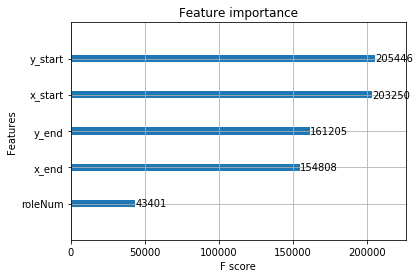

In [12]:
print(f"Train Score: {accuracy_score(y_train, model_final.predict(X_train, ntree_limit=gbm.best_ntree_limit))}.")
print(f"Validation Score: {accuracy_score(y_val, model_final.predict(X_val, ntree_limit=gbm.best_ntree_limit))}.")
xgb.plot_importance(model_final);

Let's save it!

In [13]:
# save the trained model
joblib.dump(model_final, '../../Model/AI_in_Soccer/XGBoost.pkl')
print("Final model is dumped!")

Final model is dumped!


In [14]:
# convert from DataFrame to numpy array to model in Flask
y_train_flask = y_train.values
X_train_flask = X_train.values
y_val_flask = y_val.values
X_val_flask = X_val.values

In [15]:
# Final Model - Flask version

# define model
gbm = xgb.XGBClassifier( 
                       n_estimators=30000,  # high number
                       max_depth=10,
                       objective="multi:softmax",
                       learning_rate=0.1, 
                       subsample=1,
                       min_child_weight=.1,
                       colsample_bytree=1,
                       num_class=5, 
                       random_state=42,
                       n_jobs=-1, 
                      )
# setup evaluation set
eval_set=[(X_train_flask,y_train_flask),(X_val_flask,y_val_flask)] #tracking train/val error as we go

# fit with evaluation set
model_final_flask = gbm.fit( 
                    X_train_flask, y_train_flask,
                    eval_set=eval_set,
                    eval_metric='merror',
                    early_stopping_rounds=30,  # time saver with high tree numbers
                    verbose=False 
                   )

In [16]:
# save model for Flask testing
joblib.dump(model_final_flask, '../../Model/AI_in_Soccer/XGBoost_flask.pkl')
print("model for flask is dumped!")

model for flask is dumped!


In [60]:
X_train

,x_start,y_start,x_end,y_end,roleNum
0,49,49,31,78,3
1,31,78,51,75,1
2,51,75,35,71,2
3,35,71,41,95,2
4,41,95,72,88,1
...,...,...,...,...,...
1137878,38,33,45,47,2
1137879,55,53,82,24,2
1137880,82,24,100,100,3
1137881,22,78,0,70,1


In [24]:
# test the model
a = model_final.predict_proba(X_test_d)
print(a[0])
b = model_final.predict(X_test_d)
b[0]

NameError: name 'X_test_d' is not defined

In [25]:
# check the mapping
model_final.classes_

array(['control', 'game_break', 'long_pass', 'short_pass', 'shot'],
      dtype=object)

#### Base model, np.array version to avoid the value error in Flask

In [17]:
# convert from DataFrame to numpy array to model in Flask
y_train_flask = y_train.values
X_train_flask = X_train.values
y_val_flask = y_val.values
X_val_flask = X_val.values

In [49]:
# test the model
x = [[80, 70, 3.01]]
x = np.matrix(x)
xx = model_base_b.predict_proba(x)
print(xx[0, 0])
print(xx[0, 1])
print(xx[0, 2])
print(xx[0, 3])
print(xx[0, 4])
print(xx[0, 5])
#xxx = model_base_b.predict(x)
#xxx[0]

0.08842709
0.065008715
0.23671763
0.06018328
0.49185732
0.05780603


In [41]:
type(x)

numpy.matrix

In [42]:
# check the mapping
print(model_base_b.classes_)

['control' 'cross' 'duel' 'longball' 'pass' 'shot']


In [43]:
# save model for Flask testing
# save the trained model
joblib.dump(model_base_b, '../model/gbm_base.pkl')
print("gbm_base is dumped!")

gbm_base is dumped!


#### First trial: added end coordinates and accrual event seconds

In [ ]:
# test the model
xx = model_first_a.predict_proba(X_test)
print(xx[0])
xxx = model_first_a.predict(X_test)
xxx[0]

In [ ]:
# check the mapping
model_first_a.classes_

In [ ]:
 model_

#### First Trial, np.array version to avoid the value error in Flask

In [ ]:
# retrieve performance metrics
results = gbm.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
# save the trained model
joblib.dump(gbm, 'gbm_test.pkl')
print("gbm_test is dumped!")

In [ ]:
# save the trained model
joblib.dump(gbm, 'gbm.pkl')
print("gbm is dumped!")

In [ ]:
probs = gbm.predict_proba(X_test)
y_pred = gbm.predict(X_test)

In [ ]:
x = [80, 80, 70, 70, 2, 230]

In [ ]:
a = gbm.predict_proba(x)

In [ ]:
a

In [ ]:
X_test

In [ ]:
y_train

In [ ]:
X_train.newEventSec.min()

In [ ]:
_  = X_test.copy()
_['y'] = y_test
_['y_pred'] = y_pred

In [ ]:
_.head(20)

In [ ]:
_[_.y_pred == 'Shot'].shape

In [ ]:
_[(_.x_start < 50) & (_.x_end == 0)]

In [ ]:
xgb.to_graphviz(gbm, num_trees=2)